In [108]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [2]:
fp = os.path.join(os.path.dirname(os.path.realpath('eda.ipynb')) + '/cleaned_runway.csv')

In [3]:
runway = pd.read_csv(fp)
runway.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,year,month
0,fit,420272,d,2260466,137.0,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,2016,4
1,fit,273551,b,153475,132.0,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,2013,6
2,fit,909926,c,126335,135.0,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,2014,2
3,fit,151944,b,616682,145.0,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,2016,9
4,fit,734848,b,364092,138.0,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8,45.0,2016,4


In [72]:
runway['body type'].value_counts()

hourglass            43982
athletic             37518
petite               19358
pear                 18051
straight & narrow    12866
full bust            10797
apple                 3809
Name: body type, dtype: int64

In [4]:
# Investigate what might be worth setting as label outcome
print(runway['category'].nunique())
runway['category'].value_counts()

68


dress           70474
gown            33278
sheath          14691
shift            4039
jumpsuit         4019
                ...  
sweatershirt        3
overcoat            1
crewneck            1
buttondown          1
sweatpants          1
Name: category, Length: 68, dtype: int64

In [5]:
# 68 unique categories difficult to predict, explore other categorical attributes
runway['rented for'].value_counts()
# only 8 categories!

wedding          42622
formal affair    30496
party            27198
everyday         13263
work             12124
other            11511
date              5929
vacation          3238
Name: rented for, dtype: int64

<AxesSubplot: title={'center': 'age'}, xlabel='rented for'>

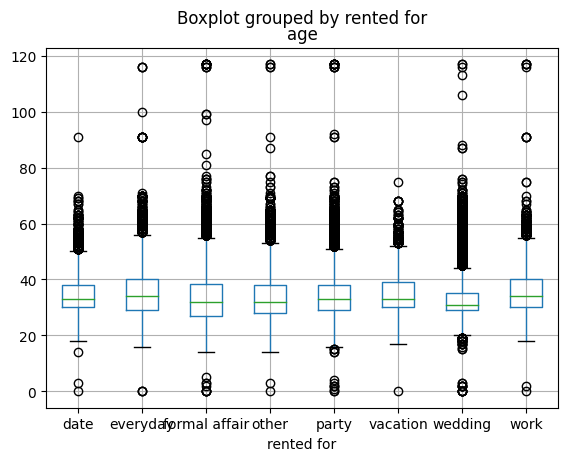

In [6]:
# are there general differences in ages between rentals for different event types?
runway.boxplot(column = 'age', by = 'rented for')

In [119]:
# run pearson chi-square test on ages between rented for categories
expected = runway['age'].mean()
age_means = runway.groupby('rented for')['age'].mean().values
data = [[expected] * len(age_means), list(age_means)]
stat, p, dof, expected = chi2_contingency(data)
p

0.9999977600592802

In [78]:
# how much of each type of clothing is purchased for each event type?
clothing_event = runway.groupby(['rented for', 'category'])['fit'].count().unstack().fillna(0)
clothing_event

category,ballgown,blazer,blouse,blouson,bomber,buttondown,caftan,cami,cape,cardigan,...,tank,tee,tight,top,trench,trouser,trousers,tunic,turtleneck,vest
rented for,,,,,,,,,,,,,,,,,,,,,
date,0.0,0.038710,0.085714,0.2,0.039216,0.0,0.00,0.083333,0.014706,0.015385,...,0.127660,0.000000,0.000000,0.093122,0.00,0.000000,0.000000,0.059701,0.043478,0.013761
everyday,0.0,0.229032,0.481633,0.4,0.764706,1.0,0.00,0.666667,0.647059,0.820513,...,0.468085,0.888889,0.769231,0.464021,0.80,0.375000,0.272727,0.559701,0.608696,0.706422
formal affair,1.0,0.019355,0.002041,0.0,0.000000,0.0,0.00,0.000000,0.044118,0.000000,...,0.000000,0.000000,0.000000,0.007937,0.00,0.000000,0.090909,0.000000,0.000000,0.004587
other,0.0,0.109677,0.044898,0.1,0.039216,0.0,0.00,0.083333,0.014706,0.030769,...,0.049645,0.000000,0.153846,0.048677,0.00,0.020833,0.090909,0.074627,0.000000,0.045872
party,0.0,0.069355,0.100000,0.1,0.068627,0.0,0.25,0.166667,0.014706,0.010256,...,0.226950,0.055556,0.000000,0.111376,0.05,0.000000,0.363636,0.134328,0.043478,0.045872
vacation,0.0,0.020968,0.034694,0.0,0.049020,0.0,0.75,0.000000,0.058824,0.020513,...,0.014184,0.055556,0.000000,0.038360,0.05,0.000000,0.000000,0.059701,0.000000,0.041284
wedding,0.0,0.008065,0.000000,0.1,0.000000,0.0,0.00,0.000000,0.014706,0.000000,...,0.000000,0.000000,0.000000,0.007937,0.00,0.000000,0.000000,0.007463,0.000000,0.000000
work,0.0,0.504839,0.251020,0.1,0.039216,0.0,0.00,0.000000,0.191176,0.102564,...,0.113475,0.000000,0.076923,0.228571,0.10,0.604167,0.181818,0.104478,0.304348,0.142202


In [103]:
# calculate proportions of clothing types for each event type
clothing_props = clothing_event / clothing_event.sum()
clothing_props

category,ballgown,blazer,blouse,blouson,bomber,buttondown,caftan,cami,cape,cardigan,...,tank,tee,tight,top,trench,trouser,trousers,tunic,turtleneck,vest
rented for,,,,,,,,,,,,,,,,,,,,,
date,0.0,0.038710,0.085714,0.2,0.039216,0.0,0.00,0.083333,0.014706,0.015385,...,0.127660,0.000000,0.000000,0.093122,0.00,0.000000,0.000000,0.059701,0.043478,0.013761
everyday,0.0,0.229032,0.481633,0.4,0.764706,1.0,0.00,0.666667,0.647059,0.820513,...,0.468085,0.888889,0.769231,0.464021,0.80,0.375000,0.272727,0.559701,0.608696,0.706422
formal affair,1.0,0.019355,0.002041,0.0,0.000000,0.0,0.00,0.000000,0.044118,0.000000,...,0.000000,0.000000,0.000000,0.007937,0.00,0.000000,0.090909,0.000000,0.000000,0.004587
other,0.0,0.109677,0.044898,0.1,0.039216,0.0,0.00,0.083333,0.014706,0.030769,...,0.049645,0.000000,0.153846,0.048677,0.00,0.020833,0.090909,0.074627,0.000000,0.045872
party,0.0,0.069355,0.100000,0.1,0.068627,0.0,0.25,0.166667,0.014706,0.010256,...,0.226950,0.055556,0.000000,0.111376,0.05,0.000000,0.363636,0.134328,0.043478,0.045872
vacation,0.0,0.020968,0.034694,0.0,0.049020,0.0,0.75,0.000000,0.058824,0.020513,...,0.014184,0.055556,0.000000,0.038360,0.05,0.000000,0.000000,0.059701,0.000000,0.041284
wedding,0.0,0.008065,0.000000,0.1,0.000000,0.0,0.00,0.000000,0.014706,0.000000,...,0.000000,0.000000,0.000000,0.007937,0.00,0.000000,0.000000,0.007463,0.000000,0.000000
work,0.0,0.504839,0.251020,0.1,0.039216,0.0,0.00,0.000000,0.191176,0.102564,...,0.113475,0.000000,0.076923,0.228571,0.10,0.604167,0.181818,0.104478,0.304348,0.142202


In [105]:
# which clothing types don't have any proportion above the threshold for any event type?
threshold = 0.3
((clothing_props < threshold).apply(all))[((clothing_props < threshold).apply(all)) == True]

category
shift     True
skirts    True
dtype: bool

In [106]:
# If the proportions of these clothings are too uniform, 
# it might be worth converting them to an "other" clothing type
clothing_props['shift']
# consists mainly of 2 event types

rented for
date             0.048279
everyday         0.063877
formal affair    0.104976
other            0.101510
party            0.273830
vacation         0.025006
wedding          0.280763
work             0.101758
Name: shift, dtype: float64

In [107]:
clothing_props['skirts']
# consists of 4 event types split evenly, this is not so bad

rented for
date             0.00
everyday         0.00
formal affair    0.25
other            0.25
party            0.25
vacation         0.00
wedding          0.00
work             0.25
Name: skirts, dtype: float64

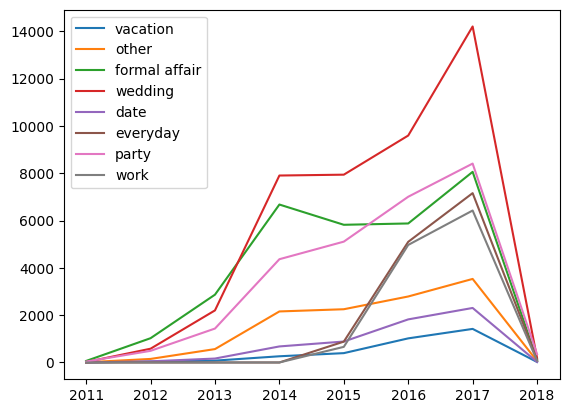

In [71]:
# how has renting for each event increased/decreased over the years?
rented_for = runway['rented for'].unique()
vals = [runway.groupby(['rented for', 'year'])['fit'].count()[clothing].values for clothing in rented_for]
# fill 0 for counts of years with 0 of two "rented for" categories
vals[5] = ([0] * 4) + list(vals[5])
vals[7] = ([0] * 4) + list(vals[7])
yrs = [yr for yr in range(2011, 2019)]
for i, clothing in enumerate(rented_for):
    plt.plot(yrs, vals[i], label = clothing)
plt.legend()
plt.show()

<AxesSubplot: title={'center': 'size'}, xlabel='rented for'>

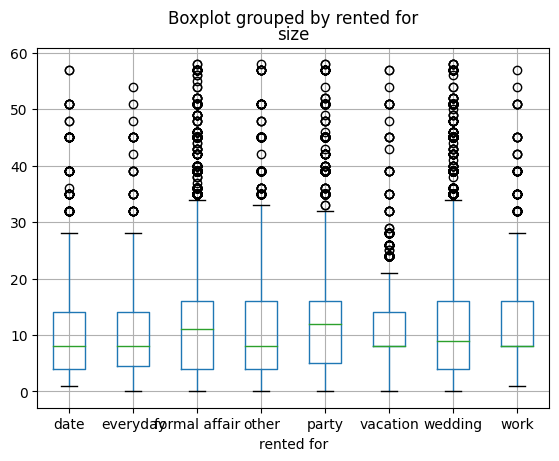

In [73]:
# do people who buy for certain events tend to wear larger/smaller sizes?
runway.boxplot(column = 'size', by = 'rented for')

In [120]:
# run pearson chi-square test on ages between rented for categories
expected = runway['size'].mean()
size_means = runway.groupby('rented for')['size'].mean().values
data = [[expected] * len(size_means), list(size_means)]
stat, p, dof, expected = chi2_contingency(data)
p

0.9999998729075146